In [3]:
import numpy as np # using version 1.22.4 as the newer version unsuitable for stable baselines 3
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import math
from stable_baselines3 import PPO
import os
import matplotlib.pyplot as plt

In [2]:
## Rastrigin Function and its directional derivatives

def ras(cord, A, B, C):
    n = cord.shape[0]
    cord = np.atleast_2d(cord).T  #Transpose 

    res = np.linalg.norm( A@cord - B )
    res = 0.5 * (res ** 2)

    angle = np.array(2 * math.pi * cord)
    tri = C@np.cos(angle)

    res = res - tri + n
  
    return res[0][0]

def grad_ras(cord, A, B, C):
    n = cord.shape[0]
    cord = np.atleast_2d(cord).T  #Transpose
    Anew = A.copy()
    res = Anew@cord - B
    res = np.append(res, [[2 * math.pi]])
    tri = np.sin(2 * math.pi * cord)
    C = np.atleast_2d(C).T
    a = np.multiply(tri, C)
    # print(a)
    # val = np.full((n, 1), a[0][0])
    Anew = np.hstack((Anew, a))
    # print(Anew)
    res = Anew@res
    return res

In [23]:
# Parameters

n = 3  # Number of dimensions of the function

# Observation space limits
HIGH = 20000
LOW = -20000

# Limits of the area in which initialization will take place
INIT_HIGH = 30 
INIT_LOW = -30

PREV = 25 # number of previous iterates to consider as states

MAX_STEP = 100 # maximum number of steps per episode, trancation if still not converged

COUNTER = 100 # maximum number of episodes for a set of parameters

# Initialization of the A,B,C parameters of the Rastrigan-like function
PARAM_MAX = 1.5
A = np.clip(np.array(np.random.normal(0, 1, size = (n, n)), dtype = np.float32), -1*PARAM_MAX, PARAM_MAX)
B = np.clip(np.array(np.random.normal(0, 1, size = (n, 1)), dtype = np.float32), -1*PARAM_MAX, PARAM_MAX)
C = np.clip(np.array(np.random.normal(0, 1, size = (1, n)), dtype = np.float32), -1*PARAM_MAX, PARAM_MAX)

TOLERANCE = 1e-5 # if the change is lower than this then the episode will terminate

BOUNDARY_PENALTY = -20000 # reward if point goes outside the boundary
MAX_GRADIENT = 20000
SCALER = 20000

In [22]:
A 

array([[ 0.70107996, -1.5       ,  0.55736744],
       [-0.13276948,  1.5       , -0.02301174],
       [ 0.03908664,  0.3477175 , -0.5903319 ]], dtype=float32)

In [29]:
# Custom environment

class L2O_RL(gym.Env):
    
    def __init__(self, n, HIGH, LOW, INIT_HIGH, INIT_LOW, PREV, MAX_STEP, COUNTER, A, B, C, TOLERANCE, BOUNDARY_PENALTY, MAX_GRADIENT, SCALER, PARAM_MAX):
        super(L2O_RL, self).__init__()
        
        # Variables
        self.n = n
        self.prev = PREV
        self.dim = (n+1)*PREV + n*n + 2*n
        
        self.high = HIGH
        self.low = LOW
        self.init_high = INIT_HIGH
        self.init_low = INIT_LOW
        
        self.step_no = 0
        self.max_step = MAX_STEP
        self.counter = COUNTER
        self.max_counter = COUNTER
        
        self.A = A
        self.B = B
        self.C = C
        
        self.tolerance = TOLERANCE
        self.boundary_penalty = BOUNDARY_PENALTY
        self.max_gradient = MAX_GRADIENT
        self.scaler = SCALER
        self.param_max = PARAM_MAX
    
        # Spaces
        self.observation_space = spaces.Box(low = LOW/SCALER, high = HIGH/SCALER, shape=(self.dim,), dtype = np.float32)
        self.action_space = spaces.Box(low = LOW/SCALER, high = HIGH/SCALER, shape=(self.n,), dtype = np.float32)
        
        # State
        self.reset_observation_and_state()
        
    def reset_observation_and_state(self):
        self.cord = np.random.uniform(self.init_low, self.init_high, self.n) # Random Initialization of the starting point
        
        self.grad = grad_ras(self.cord, self.A, self.B, self.C) # Gradient at that point
        self.value = ras(self.cord, self.A, self.B, self.C) # Value at that point
        
        self.value = min(self.value, self.high)
        
        # defining and intializing observation 
        self.observation = np.zeros(self.dim, dtype = np.float32)
        
        self.observation[self.prev:self.prev+self.n] = self.grad/self.scaler
        self.observation[self.prev*(self.n+1): self.prev*(self.n+1)+n*n] = self.A.flatten()/self.param_max
        self.observation[self.prev*(self.n+1)+n*n: self.prev*(self.n+1)+n*n+n] = self.B.flatten()/self.param_max
        self.observation[self.prev*(self.n+1)+n*n+n:self.prev*(self.n+1)+n*n+2*n] = self.C.flatten()/self.param_max
            
        
    def step(self, action):
        terminated = False
        truncated = False
        boundary_flag = False
        info = {}
        
        
        self.cord = self.cord + action # calculate new coordinates
        
        self.grad = grad_ras(self.cord, self.A, self.B, self.C) # gradient at the new coordinates
        newValue = ras(self.cord, self.A, self.B, self.C) # calculate new value
        
        
        # checking limits of coordinates, new value and gradients
        for i in range(self.n):
            if self.cord[i] > self.high:
                boundary_flag = True
                self.cord[i] = np.float32(self.high)
                
            elif self.cord[i] < self.low:
                boundary_flag = True
                self.cord[i] = np.float32(self.low)
                
        if newValue > self.high:
            boundary_flag = True
            newValue = self.high
         
        for i in range(self.n):
            self.grad[i] = min(self.grad[i], self.max_gradient)
            self.grad[i] = max(self.grad[i], (-1*self.max_gradient))
        
        
        # calculate observation
        for i in range(self.prev*(self.n+1)-1, self.prev+self.n-1, -1):
            self.observation[i] = self.observation[i-self.n]
            
        self.observation[self.prev:self.prev+self.n] = self.grad/self.scaler
        
        #for i in range(self.prev, self.prev+self.n, 1):
        #    self.observation[i] = self.grad[i-self.prev]
        
        for i in range(self.prev-1, 0, -1):
            self.observation[i] = self.observation[i-1] + (newValue - self.value)/self.scaler
            
        self.observation[0] = (newValue - self.value)/self.scaler
        
        self.value = newValue
        
        
        # truncate if more than max number of steps
        self.step_no = self.step_no + 1
        if self.step_no >= self.max_step:
            truncated = True
        
        
        # calculate reward
        if(boundary_flag == True):
            terminated = True
            reward = self.boundary_penalty/self.scaler
        else:    
            reward = -1*self.value/self.scaler
        
        # terminate if converged
        '''
        if not terminated:
            for i in range(self.n):
                if np.abs(self.dq[i] - self.dq[i+2*self.n]) <= self.tolerance:
                    terminated = True
        '''
                    
        return self.observation, reward, terminated, truncated, info
    
    def reset(self, seed = None, options = None):
        super().reset(seed=seed, options=options)
        info = {}
        
        self.step_no = 0 # for new episode
        
        if self.counter == 0:
            self.counter = self.max_counter
            print("Change")
            A = np.clip(np.array(np.random.normal(0, 1, size = (n, n)), dtype = np.float32), -1*self.param_max, self.param_max)
            B = np.clip(np.array(np.random.normal(0, 1, size = (n, 1)), dtype = np.float32), -1*self.param_max, self.param_max)
            C = np.clip(np.array(np.random.normal(0, 1, size = (1, n)), dtype = np.float32), -1*self.param_max, self.param_max)
            
        else:
            self.counter = self.counter-1
                
        self.reset_observation_and_state()
        
        return self.observation, info

In [30]:
from stable_baselines3.common.env_checker import check_env

env = L2O_RL( n, HIGH, LOW, INIT_HIGH, INIT_LOW, PREV, MAX_STEP, COUNTER, A, B, C, TOLERANCE, BOUNDARY_PENALTY, MAX_GRADIENT, SCALER, PARAM_MAX)
# It will check your custom environment and output additional warnings if needed
#check_env(env)

In [27]:
logdir = "logs"

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [31]:
print(env.observation)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.12088184e-04  1.17166215e-04 -2.55329040e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

# Training logs

In [32]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log= logdir)
model.learn(2000000, tb_log_name = "PPO")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -2.75    |
| time/              |          |
|    fps             | 3943     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.01       |
| time/                   |             |
|    fps                  | 2224        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005176399 |
|    clip_fraction        | 0.0272      |
|    clip_range           | 0.2         

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -3.51        |
| time/                   |              |
|    fps                  | 1587         |
|    iterations           | 11           |
|    time_elapsed         | 14           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0053267307 |
|    clip_fraction        | 0.0214       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.19        |
|    explained_variance   | 0.181        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.105        |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.0021      |
|    std                  | 0.978        |
|    value_loss           | 0.149        |
------------------------------------------
------------------------------------------
| rollout/ 

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.03       |
| time/                   |             |
|    fps                  | 1559        |
|    iterations           | 20          |
|    time_elapsed         | 26          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.005594967 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.18       |
|    explained_variance   | -0.0101     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00758    |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00375    |
|    std                  | 0.97        |
|    value_loss           | 0.025       |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.47       |
| time/                   |             |
|    fps                  | 1559        |
|    iterations           | 29          |
|    time_elapsed         | 38          |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.011100244 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.13       |
|    explained_variance   | 0.318       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0225      |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00205    |
|    std                  | 0.957       |
|    value_loss           | 0.0349      |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.4         |
| time/                   |              |
|    fps                  | 1581         |
|    iterations           | 38           |
|    time_elapsed         | 49           |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0051371725 |
|    clip_fraction        | 0.0695       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.12        |
|    explained_variance   | 0.159        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0594       |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00147     |
|    std                  | 0.959        |
|    value_loss           | 0.0114       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -0.953       |
| time/                   |              |
|    fps                  | 1557         |
|    iterations           | 47           |
|    time_elapsed         | 61           |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0075226477 |
|    clip_fraction        | 0.109        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.08        |
|    explained_variance   | 0.285        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00684     |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00168     |
|    std                  | 0.943        |
|    value_loss           | 0.00846      |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.787      |
| time/                   |             |
|    fps                  | 1568        |
|    iterations           | 56          |
|    time_elapsed         | 73          |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.010809684 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.08       |
|    explained_variance   | 0.251       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0204      |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.000936    |
|    std                  | 0.943       |
|    value_loss           | 0.00619     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.763      |
| time/                   |             |
|    fps                  | 1579        |
|    iterations           | 65          |
|    time_elapsed         | 84          |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.016585313 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.09       |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0111     |
|    n_updates            | 640         |
|    policy_gradient_loss | 0.00539     |
|    std                  | 0.948       |
|    value_loss           | 0.00628     |
-----------------------------------------
-----------------------------------------
| rollout/                |

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -0.682       |
| time/                   |              |
|    fps                  | 1593         |
|    iterations           | 74           |
|    time_elapsed         | 95           |
|    total_timesteps      | 151552       |
| train/                  |              |
|    approx_kl            | 0.0143072335 |
|    clip_fraction        | 0.138        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.13        |
|    explained_variance   | 0.166        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00126      |
|    n_updates            | 730          |
|    policy_gradient_loss | 0.00167      |
|    std                  | 0.961        |
|    value_loss           | 0.00604      |
------------------------------------------
-----------------------------------------
| rol

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.678     |
| time/                   |            |
|    fps                  | 1564       |
|    iterations           | 83         |
|    time_elapsed         | 108        |
|    total_timesteps      | 169984     |
| train/                  |            |
|    approx_kl            | 0.01551524 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.13      |
|    explained_variance   | 0.184      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00438   |
|    n_updates            | 820        |
|    policy_gradient_loss | 0.00101    |
|    std                  | 0.963      |
|    value_loss           | 0.0053     |
----------------------------------------
Change
-----------------------------------------
| rollout/                |             |
|    ep

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.644      |
| time/                   |             |
|    fps                  | 1536        |
|    iterations           | 92          |
|    time_elapsed         | 122         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.012931311 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.14       |
|    explained_variance   | 0.384       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00664    |
|    n_updates            | 910         |
|    policy_gradient_loss | 0.00185     |
|    std                  | 0.962       |
|    value_loss           | 0.005       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.569      |
| time/                   |             |
|    fps                  | 1522        |
|    iterations           | 101         |
|    time_elapsed         | 135         |
|    total_timesteps      | 206848      |
| train/                  |             |
|    approx_kl            | 0.016205637 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 0.258       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0107     |
|    n_updates            | 1000        |
|    policy_gradient_loss | 0.000813    |
|    std                  | 0.971       |
|    value_loss           | 0.00359     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.564      |
| time/                   |             |
|    fps                  | 1509        |
|    iterations           | 110         |
|    time_elapsed         | 149         |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.020800034 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.22       |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.014      |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.0055     |
|    std                  | 0.992       |
|    value_loss           | 0.00545     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.551      |
| time/                   |             |
|    fps                  | 1511        |
|    iterations           | 119         |
|    time_elapsed         | 161         |
|    total_timesteps      | 243712      |
| train/                  |             |
|    approx_kl            | 0.013337932 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00864     |
|    n_updates            | 1180        |
|    policy_gradient_loss | 0.00104     |
|    std                  | 1.01        |
|    value_loss           | 0.00497     |
-----------------------------------------
----------------------------------------
| rollout/                | 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.605      |
| time/                   |             |
|    fps                  | 1517        |
|    iterations           | 128         |
|    time_elapsed         | 172         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.028022794 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | 0.187       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00325    |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.00139    |
|    std                  | 1.03        |
|    value_loss           | 0.0056      |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.543      |
| time/                   |             |
|    fps                  | 1516        |
|    iterations           | 137         |
|    time_elapsed         | 185         |
|    total_timesteps      | 280576      |
| train/                  |             |
|    approx_kl            | 0.005351133 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.44       |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00187     |
|    n_updates            | 1360        |
|    policy_gradient_loss | 0.00418     |
|    std                  | 1.07        |
|    value_loss           | 0.00564     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.523     |
| time/                   |            |
|    fps                  | 1506       |
|    iterations           | 146        |
|    time_elapsed         | 198        |
|    total_timesteps      | 299008     |
| train/                  |            |
|    approx_kl            | 0.01914958 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.48      |
|    explained_variance   | 0.192      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00228   |
|    n_updates            | 1450       |
|    policy_gradient_loss | 0.00418    |
|    std                  | 1.08       |
|    value_loss           | 0.0039     |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.597      |
| time/                   |             |
|    fps                  | 1496        |
|    iterations           | 155         |
|    time_elapsed         | 212         |
|    total_timesteps      | 317440      |
| train/                  |             |
|    approx_kl            | 0.011942854 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.49       |
|    explained_variance   | 0.172       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0189     |
|    n_updates            | 1540        |
|    policy_gradient_loss | 0.00339     |
|    std                  | 1.09        |
|    value_loss           | 0.00322     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.527      |
| time/                   |             |
|    fps                  | 1492        |
|    iterations           | 164         |
|    time_elapsed         | 225         |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.011972899 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.54       |
|    explained_variance   | 0.267       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00199     |
|    n_updates            | 1630        |
|    policy_gradient_loss | 0.00328     |
|    std                  | 1.11        |
|    value_loss           | 0.00787     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.526      |
| time/                   |             |
|    fps                  | 1475        |
|    iterations           | 173         |
|    time_elapsed         | 240         |
|    total_timesteps      | 354304      |
| train/                  |             |
|    approx_kl            | 0.008445865 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.55       |
|    explained_variance   | 0.285       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00197    |
|    n_updates            | 1720        |
|    policy_gradient_loss | 0.00389     |
|    std                  | 1.11        |
|    value_loss           | 0.00423     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.536      |
| time/                   |             |
|    fps                  | 1444        |
|    iterations           | 182         |
|    time_elapsed         | 258         |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.009644372 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.6        |
|    explained_variance   | 0.0826      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00259     |
|    n_updates            | 1810        |
|    policy_gradient_loss | 0.00348     |
|    std                  | 1.13        |
|    value_loss           | 0.00196     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.554     |
| time/                   |            |
|    fps                  | 1420       |
|    iterations           | 191        |
|    time_elapsed         | 275        |
|    total_timesteps      | 391168     |
| train/                  |            |
|    approx_kl            | 0.01779855 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.62      |
|    explained_variance   | 0.285      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0116     |
|    n_updates            | 1900       |
|    policy_gradient_loss | 0.00168    |
|    std                  | 1.14       |
|    value_loss           | 0.00256    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.503     |
| time/                   |            |
|    fps                  | 1396       |
|    iterations           | 200        |
|    time_elapsed         | 293        |
|    total_timesteps      | 409600     |
| train/                  |            |
|    approx_kl            | 0.01952509 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.67      |
|    explained_variance   | 0.302      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0527     |
|    n_updates            | 1990       |
|    policy_gradient_loss | 0.00352    |
|    std                  | 1.15       |
|    value_loss           | 0.00376    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -0.498       |
| time/                   |              |
|    fps                  | 1374         |
|    iterations           | 209          |
|    time_elapsed         | 311          |
|    total_timesteps      | 428032       |
| train/                  |              |
|    approx_kl            | 0.0070222015 |
|    clip_fraction        | 0.156        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.7         |
|    explained_variance   | 0.339        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0471       |
|    n_updates            | 2080         |
|    policy_gradient_loss | 0.0036       |
|    std                  | 1.16         |
|    value_loss           | 0.00473      |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.454      |
| time/                   |             |
|    fps                  | 1356        |
|    iterations           | 218         |
|    time_elapsed         | 329         |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.013670124 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.71       |
|    explained_variance   | 0.223       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0143      |
|    n_updates            | 2170        |
|    policy_gradient_loss | 0.00424     |
|    std                  | 1.17        |
|    value_loss           | 0.00284     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.483      |
| time/                   |             |
|    fps                  | 1344        |
|    iterations           | 227         |
|    time_elapsed         | 345         |
|    total_timesteps      | 464896      |
| train/                  |             |
|    approx_kl            | 0.026806798 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.74       |
|    explained_variance   | 0.325       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0243      |
|    n_updates            | 2260        |
|    policy_gradient_loss | 0.00139     |
|    std                  | 1.19        |
|    value_loss           | 0.00483     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.519      |
| time/                   |             |
|    fps                  | 1346        |
|    iterations           | 236         |
|    time_elapsed         | 358         |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.017618323 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.88       |
|    explained_variance   | 0.144       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0132      |
|    n_updates            | 2350        |
|    policy_gradient_loss | 0.00435     |
|    std                  | 1.24        |
|    value_loss           | 0.00254     |
-----------------------------------------
Change
----------------------------------------
| rollout/                | 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.471      |
| time/                   |             |
|    fps                  | 1353        |
|    iterations           | 245         |
|    time_elapsed         | 370         |
|    total_timesteps      | 501760      |
| train/                  |             |
|    approx_kl            | 0.024267867 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.95       |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00745    |
|    n_updates            | 2440        |
|    policy_gradient_loss | 0.00255     |
|    std                  | 1.27        |
|    value_loss           | 0.00273     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.494      |
| time/                   |             |
|    fps                  | 1361        |
|    iterations           | 254         |
|    time_elapsed         | 381         |
|    total_timesteps      | 520192      |
| train/                  |             |
|    approx_kl            | 0.016483046 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.04       |
|    explained_variance   | 0.225       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0611      |
|    n_updates            | 2530        |
|    policy_gradient_loss | 0.00474     |
|    std                  | 1.31        |
|    value_loss           | 0.00309     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.478      |
| time/                   |             |
|    fps                  | 1369        |
|    iterations           | 263         |
|    time_elapsed         | 393         |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.013836165 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.11       |
|    explained_variance   | 0.157       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00521     |
|    n_updates            | 2620        |
|    policy_gradient_loss | -0.00265    |
|    std                  | 1.35        |
|    value_loss           | 0.00177     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.51       |
| time/                   |             |
|    fps                  | 1376        |
|    iterations           | 272         |
|    time_elapsed         | 404         |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.009530233 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.17       |
|    explained_variance   | 0.214       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00689     |
|    n_updates            | 2710        |
|    policy_gradient_loss | 0.00202     |
|    std                  | 1.38        |
|    value_loss           | 0.00271     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.503      |
| time/                   |             |
|    fps                  | 1383        |
|    iterations           | 281         |
|    time_elapsed         | 416         |
|    total_timesteps      | 575488      |
| train/                  |             |
|    approx_kl            | 0.015295796 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.23       |
|    explained_variance   | 0.317       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0203     |
|    n_updates            | 2800        |
|    policy_gradient_loss | 0.00165     |
|    std                  | 1.41        |
|    value_loss           | 0.0021      |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.519     |
| time/                   |            |
|    fps                  | 1390       |
|    iterations           | 290        |
|    time_elapsed         | 427        |
|    total_timesteps      | 593920     |
| train/                  |            |
|    approx_kl            | 0.01664155 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.28      |
|    explained_variance   | 0.374      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0172    |
|    n_updates            | 2890       |
|    policy_gradient_loss | 0.006      |
|    std                  | 1.42       |
|    value_loss           | 0.00356    |
----------------------------------------
Change
-----------------------------------------
| rollout/                |             |
|    ep

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.524      |
| time/                   |             |
|    fps                  | 1398        |
|    iterations           | 299         |
|    time_elapsed         | 437         |
|    total_timesteps      | 612352      |
| train/                  |             |
|    approx_kl            | 0.013704786 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.23       |
|    explained_variance   | 0.267       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0375     |
|    n_updates            | 2980        |
|    policy_gradient_loss | -0.000936   |
|    std                  | 1.4         |
|    value_loss           | 0.00392     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.519      |
| time/                   |             |
|    fps                  | 1406        |
|    iterations           | 308         |
|    time_elapsed         | 448         |
|    total_timesteps      | 630784      |
| train/                  |             |
|    approx_kl            | 0.012361346 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.22       |
|    explained_variance   | 0.321       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0287     |
|    n_updates            | 3070        |
|    policy_gradient_loss | 0.0012      |
|    std                  | 1.39        |
|    value_loss           | 0.00382     |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.448      |
| time/                   |             |
|    fps                  | 1411        |
|    iterations           | 317         |
|    time_elapsed         | 459         |
|    total_timesteps      | 649216      |
| train/                  |             |
|    approx_kl            | 0.013372311 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.16       |
|    explained_variance   | 0.25        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0118     |
|    n_updates            | 3160        |
|    policy_gradient_loss | 0.00376     |
|    std                  | 1.37        |
|    value_loss           | 0.00195     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.449      |
| time/                   |             |
|    fps                  | 1416        |
|    iterations           | 326         |
|    time_elapsed         | 471         |
|    total_timesteps      | 667648      |
| train/                  |             |
|    approx_kl            | 0.009078728 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.19       |
|    explained_variance   | 0.266       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00249    |
|    n_updates            | 3250        |
|    policy_gradient_loss | 0.00374     |
|    std                  | 1.39        |
|    value_loss           | 0.00153     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.432      |
| time/                   |             |
|    fps                  | 1420        |
|    iterations           | 335         |
|    time_elapsed         | 483         |
|    total_timesteps      | 686080      |
| train/                  |             |
|    approx_kl            | 0.013491613 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.17       |
|    explained_variance   | 0.26        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00184     |
|    n_updates            | 3340        |
|    policy_gradient_loss | 0.000472    |
|    std                  | 1.39        |
|    value_loss           | 0.00191     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.529      |
| time/                   |             |
|    fps                  | 1424        |
|    iterations           | 344         |
|    time_elapsed         | 494         |
|    total_timesteps      | 704512      |
| train/                  |             |
|    approx_kl            | 0.018090384 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.3        |
|    explained_variance   | 0.386       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00761    |
|    n_updates            | 3430        |
|    policy_gradient_loss | 0.00668     |
|    std                  | 1.43        |
|    value_loss           | 0.0039      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.434      |
| time/                   |             |
|    fps                  | 1428        |
|    iterations           | 353         |
|    time_elapsed         | 506         |
|    total_timesteps      | 722944      |
| train/                  |             |
|    approx_kl            | 0.013916303 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.29       |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00769    |
|    n_updates            | 3520        |
|    policy_gradient_loss | 0.00398     |
|    std                  | 1.44        |
|    value_loss           | 0.00164     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.44       |
| time/                   |             |
|    fps                  | 1431        |
|    iterations           | 362         |
|    time_elapsed         | 518         |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.007169337 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.3        |
|    explained_variance   | 0.215       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00508     |
|    n_updates            | 3610        |
|    policy_gradient_loss | 0.00921     |
|    std                  | 1.44        |
|    value_loss           | 0.00266     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.49       |
| time/                   |             |
|    fps                  | 1425        |
|    iterations           | 371         |
|    time_elapsed         | 533         |
|    total_timesteps      | 759808      |
| train/                  |             |
|    approx_kl            | 0.015146833 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.34       |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0213      |
|    n_updates            | 3700        |
|    policy_gradient_loss | -0.00332    |
|    std                  | 1.46        |
|    value_loss           | 0.00165     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.482      |
| time/                   |             |
|    fps                  | 1429        |
|    iterations           | 380         |
|    time_elapsed         | 544         |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.011967231 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.45       |
|    explained_variance   | 0.197       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0223     |
|    n_updates            | 3790        |
|    policy_gradient_loss | 0.00425     |
|    std                  | 1.51        |
|    value_loss           | 0.00277     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.513      |
| time/                   |             |
|    fps                  | 1436        |
|    iterations           | 389         |
|    time_elapsed         | 554         |
|    total_timesteps      | 796672      |
| train/                  |             |
|    approx_kl            | 0.012506502 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.47       |
|    explained_variance   | 0.331       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0414     |
|    n_updates            | 3880        |
|    policy_gradient_loss | 0.00341     |
|    std                  | 1.52        |
|    value_loss           | 0.00459     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.525     |
| time/                   |            |
|    fps                  | 1442       |
|    iterations           | 398        |
|    time_elapsed         | 565        |
|    total_timesteps      | 815104     |
| train/                  |            |
|    approx_kl            | 0.00840757 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.46      |
|    explained_variance   | 0.382      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0209     |
|    n_updates            | 3970       |
|    policy_gradient_loss | 0.00375    |
|    std                  | 1.52       |
|    value_loss           | 0.00369    |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -0.529       |
| time/                   |              |
|    fps                  | 1442         |
|    iterations           | 407          |
|    time_elapsed         | 577          |
|    total_timesteps      | 833536       |
| train/                  |              |
|    approx_kl            | 0.0137513345 |
|    clip_fraction        | 0.141        |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.5         |
|    explained_variance   | 0.197        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00716     |
|    n_updates            | 4060         |
|    policy_gradient_loss | 0.00126      |
|    std                  | 1.54         |
|    value_loss           | 0.00244      |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.617      |
| time/                   |             |
|    fps                  | 1437        |
|    iterations           | 416         |
|    time_elapsed         | 592         |
|    total_timesteps      | 851968      |
| train/                  |             |
|    approx_kl            | 0.012592681 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.5        |
|    explained_variance   | 0.278       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00678     |
|    n_updates            | 4150        |
|    policy_gradient_loss | 0.00418     |
|    std                  | 1.54        |
|    value_loss           | 0.00248     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.513      |
| time/                   |             |
|    fps                  | 1434        |
|    iterations           | 425         |
|    time_elapsed         | 606         |
|    total_timesteps      | 870400      |
| train/                  |             |
|    approx_kl            | 0.018529173 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.47       |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0254      |
|    n_updates            | 4240        |
|    policy_gradient_loss | 0.00274     |
|    std                  | 1.52        |
|    value_loss           | 0.00373     |
-----------------------------------------
------------------------------------------
| rollout/                

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.493      |
| time/                   |             |
|    fps                  | 1436        |
|    iterations           | 434         |
|    time_elapsed         | 618         |
|    total_timesteps      | 888832      |
| train/                  |             |
|    approx_kl            | 0.020740332 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.49       |
|    explained_variance   | 0.296       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00376     |
|    n_updates            | 4330        |
|    policy_gradient_loss | 0.00237     |
|    std                  | 1.53        |
|    value_loss           | 0.00271     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.416      |
| time/                   |             |
|    fps                  | 1440        |
|    iterations           | 443         |
|    time_elapsed         | 629         |
|    total_timesteps      | 907264      |
| train/                  |             |
|    approx_kl            | 0.013475425 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.4        |
|    explained_variance   | 0.365       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0194      |
|    n_updates            | 4420        |
|    policy_gradient_loss | 0.00101     |
|    std                  | 1.48        |
|    value_loss           | 0.00245     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.5        |
| time/                   |             |
|    fps                  | 1444        |
|    iterations           | 452         |
|    time_elapsed         | 640         |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.011335269 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.44       |
|    explained_variance   | 0.307       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0142      |
|    n_updates            | 4510        |
|    policy_gradient_loss | 0.00702     |
|    std                  | 1.51        |
|    value_loss           | 0.00207     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.503     |
| time/                   |            |
|    fps                  | 1448       |
|    iterations           | 461        |
|    time_elapsed         | 651        |
|    total_timesteps      | 944128     |
| train/                  |            |
|    approx_kl            | 0.01196623 |
|    clip_fraction        | 0.149      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.52      |
|    explained_variance   | 0.252      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00532   |
|    n_updates            | 4600       |
|    policy_gradient_loss | 0.00392    |
|    std                  | 1.54       |
|    value_loss           | 0.00225    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.448      |
| time/                   |             |
|    fps                  | 1448        |
|    iterations           | 470         |
|    time_elapsed         | 664         |
|    total_timesteps      | 962560      |
| train/                  |             |
|    approx_kl            | 0.008101584 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.5        |
|    explained_variance   | 0.334       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0076     |
|    n_updates            | 4690        |
|    policy_gradient_loss | 0.00203     |
|    std                  | 1.54        |
|    value_loss           | 0.00264     |
-----------------------------------------
----------------------------------------
| rollout/                |        

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.461      |
| time/                   |             |
|    fps                  | 1446        |
|    iterations           | 479         |
|    time_elapsed         | 678         |
|    total_timesteps      | 980992      |
| train/                  |             |
|    approx_kl            | 0.011372858 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.53       |
|    explained_variance   | 0.323       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0136     |
|    n_updates            | 4780        |
|    policy_gradient_loss | 0.00223     |
|    std                  | 1.56        |
|    value_loss           | 0.00244     |
-----------------------------------------
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.545     |
| time/                   |            |
|    fps                  | 1444       |
|    iterations           | 488        |
|    time_elapsed         | 691        |
|    total_timesteps      | 999424     |
| train/                  |            |
|    approx_kl            | 0.01701039 |
|    clip_fraction        | 0.207      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.54      |
|    explained_variance   | 0.312      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0037    |
|    n_updates            | 4870       |
|    policy_gradient_loss | 0.000849   |
|    std                  | 1.56       |
|    value_loss           | 0.00443    |
----------------------------------------
Change
-----------------------------------------
| rollout/                |             |
|    ep

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.426      |
| time/                   |             |
|    fps                  | 1444        |
|    iterations           | 497         |
|    time_elapsed         | 704         |
|    total_timesteps      | 1017856     |
| train/                  |             |
|    approx_kl            | 0.007029791 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.58       |
|    explained_variance   | 0.13        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0173      |
|    n_updates            | 4960        |
|    policy_gradient_loss | 0.00254     |
|    std                  | 1.58        |
|    value_loss           | 0.00127     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.537      |
| time/                   |             |
|    fps                  | 1444        |
|    iterations           | 506         |
|    time_elapsed         | 717         |
|    total_timesteps      | 1036288     |
| train/                  |             |
|    approx_kl            | 0.013616795 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.69       |
|    explained_variance   | 0.11        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0153     |
|    n_updates            | 5050        |
|    policy_gradient_loss | -0.00228    |
|    std                  | 1.64        |
|    value_loss           | 0.00236     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.464      |
| time/                   |             |
|    fps                  | 1448        |
|    iterations           | 515         |
|    time_elapsed         | 727         |
|    total_timesteps      | 1054720     |
| train/                  |             |
|    approx_kl            | 0.006237066 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.67       |
|    explained_variance   | 0.384       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0601      |
|    n_updates            | 5140        |
|    policy_gradient_loss | 0.0065      |
|    std                  | 1.63        |
|    value_loss           | 0.00255     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.456      |
| time/                   |             |
|    fps                  | 1447        |
|    iterations           | 524         |
|    time_elapsed         | 741         |
|    total_timesteps      | 1073152     |
| train/                  |             |
|    approx_kl            | 0.011186821 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.7        |
|    explained_variance   | 0.172       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00712    |
|    n_updates            | 5230        |
|    policy_gradient_loss | 0.00364     |
|    std                  | 1.64        |
|    value_loss           | 0.00181     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.488      |
| time/                   |             |
|    fps                  | 1441        |
|    iterations           | 533         |
|    time_elapsed         | 757         |
|    total_timesteps      | 1091584     |
| train/                  |             |
|    approx_kl            | 0.018405847 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.66       |
|    explained_variance   | 0.151       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0186     |
|    n_updates            | 5320        |
|    policy_gradient_loss | 0.00364     |
|    std                  | 1.62        |
|    value_loss           | 0.00162     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.527      |
| time/                   |             |
|    fps                  | 1433        |
|    iterations           | 542         |
|    time_elapsed         | 774         |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.011645993 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.73       |
|    explained_variance   | 0.282       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0436      |
|    n_updates            | 5410        |
|    policy_gradient_loss | 0.00521     |
|    std                  | 1.67        |
|    value_loss           | 0.00207     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.457      |
| time/                   |             |
|    fps                  | 1424        |
|    iterations           | 551         |
|    time_elapsed         | 792         |
|    total_timesteps      | 1128448     |
| train/                  |             |
|    approx_kl            | 0.018945668 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.88       |
|    explained_variance   | 0.411       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0264      |
|    n_updates            | 5500        |
|    policy_gradient_loss | 0.00424     |
|    std                  | 1.76        |
|    value_loss           | 0.00265     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.438     |
| time/                   |            |
|    fps                  | 1415       |
|    iterations           | 560        |
|    time_elapsed         | 810        |
|    total_timesteps      | 1146880    |
| train/                  |            |
|    approx_kl            | 0.02059629 |
|    clip_fraction        | 0.179      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.93      |
|    explained_variance   | 0.388      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.043      |
|    n_updates            | 5590       |
|    policy_gradient_loss | 0.00422    |
|    std                  | 1.78       |
|    value_loss           | 0.00225    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.437      |
| time/                   |             |
|    fps                  | 1407        |
|    iterations           | 569         |
|    time_elapsed         | 827         |
|    total_timesteps      | 1165312     |
| train/                  |             |
|    approx_kl            | 0.012488371 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.98       |
|    explained_variance   | 0.281       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0206     |
|    n_updates            | 5680        |
|    policy_gradient_loss | 0.0018      |
|    std                  | 1.81        |
|    value_loss           | 0.00182     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.421      |
| time/                   |             |
|    fps                  | 1399        |
|    iterations           | 578         |
|    time_elapsed         | 845         |
|    total_timesteps      | 1183744     |
| train/                  |             |
|    approx_kl            | 0.024392411 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.01       |
|    explained_variance   | 0.357       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0286      |
|    n_updates            | 5770        |
|    policy_gradient_loss | 0.00401     |
|    std                  | 1.83        |
|    value_loss           | 0.00204     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -0.457       |
| time/                   |              |
|    fps                  | 1392         |
|    iterations           | 587          |
|    time_elapsed         | 863          |
|    total_timesteps      | 1202176      |
| train/                  |              |
|    approx_kl            | 0.0073211472 |
|    clip_fraction        | 0.158        |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.07        |
|    explained_variance   | 0.355        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0382       |
|    n_updates            | 5860         |
|    policy_gradient_loss | 0.0046       |
|    std                  | 1.87         |
|    value_loss           | 0.00411      |
------------------------------------------
-----------------------------------------
| rol

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.53      |
| time/                   |            |
|    fps                  | 1385       |
|    iterations           | 596        |
|    time_elapsed         | 880        |
|    total_timesteps      | 1220608    |
| train/                  |            |
|    approx_kl            | 0.01475506 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.04      |
|    explained_variance   | 0.313      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0485     |
|    n_updates            | 5950       |
|    policy_gradient_loss | 0.00652    |
|    std                  | 1.84       |
|    value_loss           | 0.00299    |
----------------------------------------
Change
-----------------------------------------
| rollout/                |             |
|    ep

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 100       |
|    ep_rew_mean          | -0.493    |
| time/                   |           |
|    fps                  | 1378      |
|    iterations           | 605       |
|    time_elapsed         | 898       |
|    total_timesteps      | 1239040   |
| train/                  |           |
|    approx_kl            | 0.0169036 |
|    clip_fraction        | 0.198     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.08     |
|    explained_variance   | 0.38      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0299    |
|    n_updates            | 6040      |
|    policy_gradient_loss | 0.000511  |
|    std                  | 1.87      |
|    value_loss           | 0.00391   |
---------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.472      |
| time/                   |             |
|    fps                  | 1371        |
|    iterations           | 614         |
|    time_elapsed         | 916         |
|    total_timesteps      | 1257472     |
| train/                  |             |
|    approx_kl            | 0.011344265 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.15       |
|    explained_variance   | 0.358       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0119     |
|    n_updates            | 6130        |
|    policy_gradient_loss | 0.00225     |
|    std                  | 1.92        |
|    value_loss           | 0.00269     |
-----------------------------------------
----------------------------------------
| rollout/                |        

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.503     |
| time/                   |            |
|    fps                  | 1365       |
|    iterations           | 623        |
|    time_elapsed         | 934        |
|    total_timesteps      | 1275904    |
| train/                  |            |
|    approx_kl            | 0.02129627 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.18      |
|    explained_variance   | 0.315      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00521   |
|    n_updates            | 6220       |
|    policy_gradient_loss | 0.00242    |
|    std                  | 1.94       |
|    value_loss           | 0.00312    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.476      |
| time/                   |             |
|    fps                  | 1358        |
|    iterations           | 632         |
|    time_elapsed         | 953         |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.015697574 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.2        |
|    explained_variance   | 0.335       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0242      |
|    n_updates            | 6310        |
|    policy_gradient_loss | 0.00161     |
|    std                  | 1.95        |
|    value_loss           | 0.0026      |
-----------------------------------------
-----------------------------------------
| rollout/                |

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -0.408       |
| time/                   |              |
|    fps                  | 1352         |
|    iterations           | 641          |
|    time_elapsed         | 970          |
|    total_timesteps      | 1312768      |
| train/                  |              |
|    approx_kl            | 0.0048192227 |
|    clip_fraction        | 0.149        |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.34        |
|    explained_variance   | 0.409        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00951     |
|    n_updates            | 6400         |
|    policy_gradient_loss | 0.005        |
|    std                  | 2.04         |
|    value_loss           | 0.0021       |
------------------------------------------
Change
----------------------------------------
| roll

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.46       |
| time/                   |             |
|    fps                  | 1346        |
|    iterations           | 650         |
|    time_elapsed         | 988         |
|    total_timesteps      | 1331200     |
| train/                  |             |
|    approx_kl            | 0.008746992 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.38       |
|    explained_variance   | 0.349       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.013      |
|    n_updates            | 6490        |
|    policy_gradient_loss | 0.00139     |
|    std                  | 2.09        |
|    value_loss           | 0.00198     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.463      |
| time/                   |             |
|    fps                  | 1341        |
|    iterations           | 659         |
|    time_elapsed         | 1006        |
|    total_timesteps      | 1349632     |
| train/                  |             |
|    approx_kl            | 0.019314025 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.47       |
|    explained_variance   | 0.268       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.019      |
|    n_updates            | 6580        |
|    policy_gradient_loss | 0.0023      |
|    std                  | 2.13        |
|    value_loss           | 0.00223     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.45      |
| time/                   |            |
|    fps                  | 1335       |
|    iterations           | 668        |
|    time_elapsed         | 1024       |
|    total_timesteps      | 1368064    |
| train/                  |            |
|    approx_kl            | 0.00886558 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.46      |
|    explained_variance   | 0.172      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0106    |
|    n_updates            | 6670       |
|    policy_gradient_loss | 0.00306    |
|    std                  | 2.13       |
|    value_loss           | 0.00222    |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.47      |
| time/                   |            |
|    fps                  | 1332       |
|    iterations           | 677        |
|    time_elapsed         | 1040       |
|    total_timesteps      | 1386496    |
| train/                  |            |
|    approx_kl            | 0.01740736 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.56      |
|    explained_variance   | 0.466      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00867   |
|    n_updates            | 6760       |
|    policy_gradient_loss | 0.000185   |
|    std                  | 2.2        |
|    value_loss           | 0.00299    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.456      |
| time/                   |             |
|    fps                  | 1332        |
|    iterations           | 686         |
|    time_elapsed         | 1054        |
|    total_timesteps      | 1404928     |
| train/                  |             |
|    approx_kl            | 0.019445026 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.54       |
|    explained_variance   | 0.319       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000254   |
|    n_updates            | 6850        |
|    policy_gradient_loss | 0.00325     |
|    std                  | 2.17        |
|    value_loss           | 0.00178     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.444      |
| time/                   |             |
|    fps                  | 1336        |
|    iterations           | 695         |
|    time_elapsed         | 1065        |
|    total_timesteps      | 1423360     |
| train/                  |             |
|    approx_kl            | 0.017647449 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.54       |
|    explained_variance   | 0.454       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0196     |
|    n_updates            | 6940        |
|    policy_gradient_loss | 0.000302    |
|    std                  | 2.17        |
|    value_loss           | 0.00321     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.453      |
| time/                   |             |
|    fps                  | 1338        |
|    iterations           | 704         |
|    time_elapsed         | 1077        |
|    total_timesteps      | 1441792     |
| train/                  |             |
|    approx_kl            | 0.011830103 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.5        |
|    explained_variance   | 0.363       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00521    |
|    n_updates            | 7030        |
|    policy_gradient_loss | 0.00323     |
|    std                  | 2.14        |
|    value_loss           | 0.00242     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.433      |
| time/                   |             |
|    fps                  | 1339        |
|    iterations           | 713         |
|    time_elapsed         | 1090        |
|    total_timesteps      | 1460224     |
| train/                  |             |
|    approx_kl            | 0.010943828 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.55       |
|    explained_variance   | 0.177       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00331    |
|    n_updates            | 7120        |
|    policy_gradient_loss | 0.00473     |
|    std                  | 2.19        |
|    value_loss           | 0.000967    |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.439      |
| time/                   |             |
|    fps                  | 1342        |
|    iterations           | 722         |
|    time_elapsed         | 1101        |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.010355168 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.68       |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0056      |
|    n_updates            | 7210        |
|    policy_gradient_loss | 0.000559    |
|    std                  | 2.29        |
|    value_loss           | 0.00123     |
-----------------------------------------
---------------------------------------
| rollout/                |         

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.506      |
| time/                   |             |
|    fps                  | 1345        |
|    iterations           | 731         |
|    time_elapsed         | 1112        |
|    total_timesteps      | 1497088     |
| train/                  |             |
|    approx_kl            | 0.014027153 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.58       |
|    explained_variance   | 0.328       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00291    |
|    n_updates            | 7300        |
|    policy_gradient_loss | -0.00174    |
|    std                  | 2.2         |
|    value_loss           | 0.00155     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.483      |
| time/                   |             |
|    fps                  | 1349        |
|    iterations           | 740         |
|    time_elapsed         | 1123        |
|    total_timesteps      | 1515520     |
| train/                  |             |
|    approx_kl            | 0.017513482 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.53       |
|    explained_variance   | 0.305       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0259     |
|    n_updates            | 7390        |
|    policy_gradient_loss | 0.00154     |
|    std                  | 2.18        |
|    value_loss           | 0.00199     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.468      |
| time/                   |             |
|    fps                  | 1352        |
|    iterations           | 749         |
|    time_elapsed         | 1134        |
|    total_timesteps      | 1533952     |
| train/                  |             |
|    approx_kl            | 0.010641264 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.53       |
|    explained_variance   | 0.349       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.023      |
|    n_updates            | 7480        |
|    policy_gradient_loss | 0.00262     |
|    std                  | 2.18        |
|    value_loss           | 0.00241     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.529      |
| time/                   |             |
|    fps                  | 1354        |
|    iterations           | 758         |
|    time_elapsed         | 1145        |
|    total_timesteps      | 1552384     |
| train/                  |             |
|    approx_kl            | 0.015792727 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.6        |
|    explained_variance   | 0.383       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00933    |
|    n_updates            | 7570        |
|    policy_gradient_loss | 0.000449    |
|    std                  | 2.24        |
|    value_loss           | 0.00287     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.424      |
| time/                   |             |
|    fps                  | 1358        |
|    iterations           | 767         |
|    time_elapsed         | 1156        |
|    total_timesteps      | 1570816     |
| train/                  |             |
|    approx_kl            | 0.015600621 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.67       |
|    explained_variance   | 0.155       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00787    |
|    n_updates            | 7660        |
|    policy_gradient_loss | 0.00131     |
|    std                  | 2.28        |
|    value_loss           | 0.00155     |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.434      |
| time/                   |             |
|    fps                  | 1361        |
|    iterations           | 776         |
|    time_elapsed         | 1167        |
|    total_timesteps      | 1589248     |
| train/                  |             |
|    approx_kl            | 0.015831623 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.71       |
|    explained_variance   | 0.348       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0177     |
|    n_updates            | 7750        |
|    policy_gradient_loss | 0.00328     |
|    std                  | 2.32        |
|    value_loss           | 0.00202     |
-----------------------------------------
----------------------------------------
| rollout/                |        

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.424      |
| time/                   |             |
|    fps                  | 1365        |
|    iterations           | 785         |
|    time_elapsed         | 1177        |
|    total_timesteps      | 1607680     |
| train/                  |             |
|    approx_kl            | 0.010893723 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.75       |
|    explained_variance   | 0.37        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0041     |
|    n_updates            | 7840        |
|    policy_gradient_loss | 0.00157     |
|    std                  | 2.36        |
|    value_loss           | 0.00184     |
-----------------------------------------
-----------------------------------------
| rollout/                |

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.418      |
| time/                   |             |
|    fps                  | 1369        |
|    iterations           | 794         |
|    time_elapsed         | 1187        |
|    total_timesteps      | 1626112     |
| train/                  |             |
|    approx_kl            | 0.010664843 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.71       |
|    explained_variance   | 0.302       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0243      |
|    n_updates            | 7930        |
|    policy_gradient_loss | 0.00359     |
|    std                  | 2.32        |
|    value_loss           | 0.00126     |
-----------------------------------------
----------------------------------------
| rollout/                | 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.445      |
| time/                   |             |
|    fps                  | 1373        |
|    iterations           | 803         |
|    time_elapsed         | 1197        |
|    total_timesteps      | 1644544     |
| train/                  |             |
|    approx_kl            | 0.016408626 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.71       |
|    explained_variance   | 0.329       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00673    |
|    n_updates            | 8020        |
|    policy_gradient_loss | 0.00153     |
|    std                  | 2.33        |
|    value_loss           | 0.00132     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.447      |
| time/                   |             |
|    fps                  | 1377        |
|    iterations           | 812         |
|    time_elapsed         | 1207        |
|    total_timesteps      | 1662976     |
| train/                  |             |
|    approx_kl            | 0.019192455 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.74       |
|    explained_variance   | 0.3         |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0351     |
|    n_updates            | 8110        |
|    policy_gradient_loss | 0.00253     |
|    std                  | 2.34        |
|    value_loss           | 0.00158     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.407      |
| time/                   |             |
|    fps                  | 1380        |
|    iterations           | 821         |
|    time_elapsed         | 1217        |
|    total_timesteps      | 1681408     |
| train/                  |             |
|    approx_kl            | 0.012066307 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.76       |
|    explained_variance   | 0.327       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0335     |
|    n_updates            | 8200        |
|    policy_gradient_loss | 0.000883    |
|    std                  | 2.35        |
|    value_loss           | 0.00281     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.445      |
| time/                   |             |
|    fps                  | 1384        |
|    iterations           | 830         |
|    time_elapsed         | 1227        |
|    total_timesteps      | 1699840     |
| train/                  |             |
|    approx_kl            | 0.009418376 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.74       |
|    explained_variance   | 0.3         |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0092      |
|    n_updates            | 8290        |
|    policy_gradient_loss | 0.00186     |
|    std                  | 2.33        |
|    value_loss           | 0.00179     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.446      |
| time/                   |             |
|    fps                  | 1387        |
|    iterations           | 839         |
|    time_elapsed         | 1238        |
|    total_timesteps      | 1718272     |
| train/                  |             |
|    approx_kl            | 0.022521738 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.89       |
|    explained_variance   | 0.335       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0135      |
|    n_updates            | 8380        |
|    policy_gradient_loss | 0.00281     |
|    std                  | 2.45        |
|    value_loss           | 0.00267     |
-----------------------------------------
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.458     |
| time/                   |            |
|    fps                  | 1390       |
|    iterations           | 848        |
|    time_elapsed         | 1249       |
|    total_timesteps      | 1736704    |
| train/                  |            |
|    approx_kl            | 0.01044555 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.9       |
|    explained_variance   | 0.467      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00751   |
|    n_updates            | 8470       |
|    policy_gradient_loss | 0.001      |
|    std                  | 2.46       |
|    value_loss           | 0.00231    |
----------------------------------------
Change
-----------------------------------------
| rollout/                |             |
|    ep

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.487      |
| time/                   |             |
|    fps                  | 1389        |
|    iterations           | 857         |
|    time_elapsed         | 1263        |
|    total_timesteps      | 1755136     |
| train/                  |             |
|    approx_kl            | 0.012852559 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.91       |
|    explained_variance   | 0.329       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0233      |
|    n_updates            | 8560        |
|    policy_gradient_loss | 0.000459    |
|    std                  | 2.45        |
|    value_loss           | 0.00198     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.453      |
| time/                   |             |
|    fps                  | 1388        |
|    iterations           | 866         |
|    time_elapsed         | 1277        |
|    total_timesteps      | 1773568     |
| train/                  |             |
|    approx_kl            | 0.014012679 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.96       |
|    explained_variance   | 0.284       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0144      |
|    n_updates            | 8650        |
|    policy_gradient_loss | 0.00524     |
|    std                  | 2.5         |
|    value_loss           | 0.00153     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -0.431     |
| time/                   |            |
|    fps                  | 1385       |
|    iterations           | 875        |
|    time_elapsed         | 1293       |
|    total_timesteps      | 1792000    |
| train/                  |            |
|    approx_kl            | 0.01738777 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.92      |
|    explained_variance   | 0.335      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0292    |
|    n_updates            | 8740       |
|    policy_gradient_loss | 4.28e-05   |
|    std                  | 2.47       |
|    value_loss           | 0.00107    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.416      |
| time/                   |             |
|    fps                  | 1380        |
|    iterations           | 884         |
|    time_elapsed         | 1311        |
|    total_timesteps      | 1810432     |
| train/                  |             |
|    approx_kl            | 0.022342615 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.9        |
|    explained_variance   | 0.272       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0122      |
|    n_updates            | 8830        |
|    policy_gradient_loss | 0.00127     |
|    std                  | 2.46        |
|    value_loss           | 0.00149     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.505      |
| time/                   |             |
|    fps                  | 1375        |
|    iterations           | 893         |
|    time_elapsed         | 1329        |
|    total_timesteps      | 1828864     |
| train/                  |             |
|    approx_kl            | 0.009795846 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.96       |
|    explained_variance   | 0.228       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.004      |
|    n_updates            | 8920        |
|    policy_gradient_loss | -0.000109   |
|    std                  | 2.51        |
|    value_loss           | 0.000895    |
-----------------------------------------
-----------------------------------------
| rollout/                |

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -0.462       |
| time/                   |              |
|    fps                  | 1371         |
|    iterations           | 902          |
|    time_elapsed         | 1346         |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.0120621035 |
|    clip_fraction        | 0.156        |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.98        |
|    explained_variance   | 0.0835       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000809     |
|    n_updates            | 9010         |
|    policy_gradient_loss | -0.00122     |
|    std                  | 2.54         |
|    value_loss           | 0.00147      |
------------------------------------------
Change
------------------------------------------
| ro

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -0.448       |
| time/                   |              |
|    fps                  | 1367         |
|    iterations           | 911          |
|    time_elapsed         | 1364         |
|    total_timesteps      | 1865728      |
| train/                  |              |
|    approx_kl            | 0.0067429272 |
|    clip_fraction        | 0.135        |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.1         |
|    explained_variance   | 0.395        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00291      |
|    n_updates            | 9100         |
|    policy_gradient_loss | 0.00138      |
|    std                  | 2.65         |
|    value_loss           | 0.00231      |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.496      |
| time/                   |             |
|    fps                  | 1362        |
|    iterations           | 920         |
|    time_elapsed         | 1382        |
|    total_timesteps      | 1884160     |
| train/                  |             |
|    approx_kl            | 0.015695833 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.1        |
|    explained_variance   | 0.386       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0218      |
|    n_updates            | 9190        |
|    policy_gradient_loss | -0.000396   |
|    std                  | 2.66        |
|    value_loss           | 0.0039      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.445      |
| time/                   |             |
|    fps                  | 1358        |
|    iterations           | 929         |
|    time_elapsed         | 1400        |
|    total_timesteps      | 1902592     |
| train/                  |             |
|    approx_kl            | 0.013539564 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.11       |
|    explained_variance   | 0.357       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0159      |
|    n_updates            | 9280        |
|    policy_gradient_loss | -2.02e-05   |
|    std                  | 2.64        |
|    value_loss           | 0.00196     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -0.46        |
| time/                   |              |
|    fps                  | 1353         |
|    iterations           | 938          |
|    time_elapsed         | 1418         |
|    total_timesteps      | 1921024      |
| train/                  |              |
|    approx_kl            | 0.0061809253 |
|    clip_fraction        | 0.17         |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.07        |
|    explained_variance   | 0.191        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000423     |
|    n_updates            | 9370         |
|    policy_gradient_loss | 0.00495      |
|    std                  | 2.61         |
|    value_loss           | 0.00193      |
------------------------------------------
-----------------------------------------
| rollout/  

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.465      |
| time/                   |             |
|    fps                  | 1349        |
|    iterations           | 947         |
|    time_elapsed         | 1436        |
|    total_timesteps      | 1939456     |
| train/                  |             |
|    approx_kl            | 0.012754506 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.07       |
|    explained_variance   | 0.337       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00405     |
|    n_updates            | 9460        |
|    policy_gradient_loss | -0.00181    |
|    std                  | 2.59        |
|    value_loss           | 0.00259     |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.528      |
| time/                   |             |
|    fps                  | 1345        |
|    iterations           | 956         |
|    time_elapsed         | 1455        |
|    total_timesteps      | 1957888     |
| train/                  |             |
|    approx_kl            | 0.008741792 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.13       |
|    explained_variance   | 0.329       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.015      |
|    n_updates            | 9550        |
|    policy_gradient_loss | 0.00242     |
|    std                  | 2.63        |
|    value_loss           | 0.00299     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.457      |
| time/                   |             |
|    fps                  | 1341        |
|    iterations           | 965         |
|    time_elapsed         | 1473        |
|    total_timesteps      | 1976320     |
| train/                  |             |
|    approx_kl            | 0.009590227 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.07       |
|    explained_variance   | 0.292       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00345    |
|    n_updates            | 9640        |
|    policy_gradient_loss | 0.00389     |
|    std                  | 2.58        |
|    value_loss           | 0.00195     |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -0.472      |
| time/                   |             |
|    fps                  | 1337        |
|    iterations           | 974         |
|    time_elapsed         | 1491        |
|    total_timesteps      | 1994752     |
| train/                  |             |
|    approx_kl            | 0.020970883 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.07       |
|    explained_variance   | 0.391       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000592    |
|    n_updates            | 9730        |
|    policy_gradient_loss | 0.00253     |
|    std                  | 2.61        |
|    value_loss           | 0.00238     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

In [33]:
model.save("./models/model-v2") # added a,b,c input 

# Evaluation logs

In [24]:
iteration = 100
lr = 0.003

## Evaluataion
val_gd = []
val_rl = []

env.reset()

A, B, C = env.A, env.B, env.C #A,B,C values
xyz_int = np.random.uniform(env.init_low, env.init_high, env.n)
xyz_rl = xyz_int
xyz_gd = xyz_int

grad = grad_ras(xyz_int, A, B, C)
oldvalue = ras(xyz_int, A, B, C)
        
observation = np.zeros(env.dim, dtype = np.float32)
for j in range(env.prev):
    for i in range(env.n):
        observation[env.prev+i+j*n] = grad[i] # initializing with all gradients

val_gd.append(oldvalue)
val_rl.append(oldvalue)
        
for i in range(iteration):
    # gradient descent
    xyz_gd = xyz_gd - lr*grad_ras(xyz_gd, A, B, C)
    val_gd.append(ras(xyz_gd, A, B, C))
    
    # reinforcement learning
    xyz_rl = xyz_rl + model.predict(observation)[0]
    
    grad = grad_ras(xyz_rl, A, B, C)
    newvalue = ras(xyz_rl, A, B, C)
    
    for i in range(env.dim-1, env.prev+env.n-1, -1):
        observation[i] = observation[i-env.n]
    for i in range(env.prev, env.prev+env.n, 1):
        observation[i] = grad[i-env.prev]
    for i in range(env.prev-1, 0, -1):
        observation[i] = observation[i-1] + newvalue - oldvalue
    observation[0] = newvalue - oldvalue
        
    oldvalue = newvalue
    
    val_rl.append(ras(xyz_rl, A, B, C))    

Change


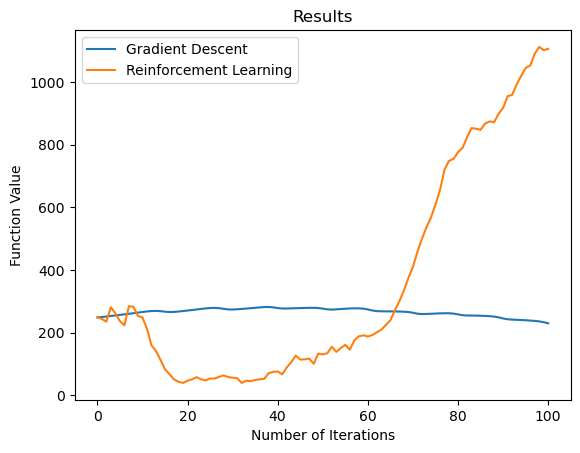

In [11]:
plt.plot(val_gd, label ="Gradient Descent")
plt.plot(val_rl, label ="Reinforcement Learning")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Function Value")
plt.title("Results")
plt.show()

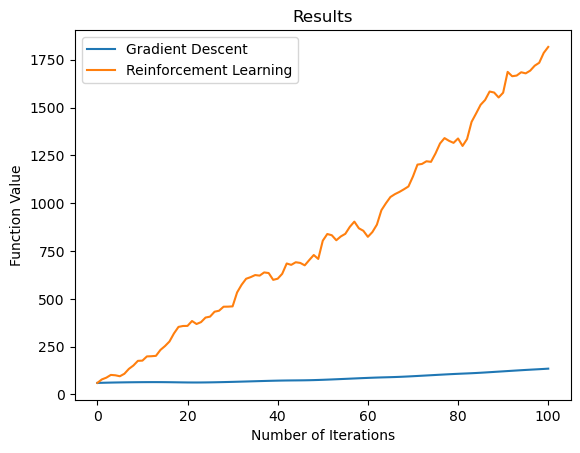

In [13]:
plt.plot(val_gd, label ="Gradient Descent")
plt.plot(val_rl, label ="Reinforcement Learning")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Function Value")
plt.title("Results")
plt.show()

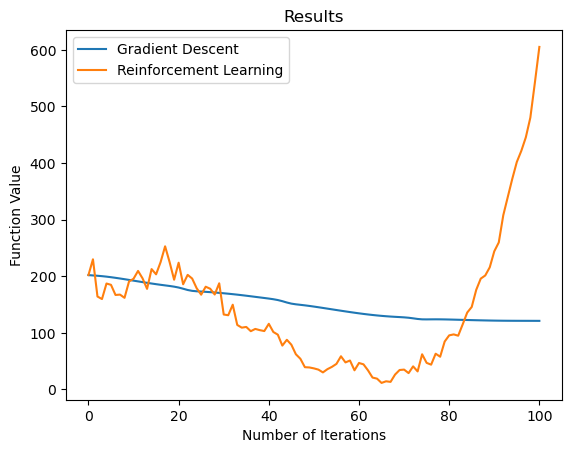

In [15]:
plt.plot(val_gd, label ="Gradient Descent")
plt.plot(val_rl, label ="Reinforcement Learning")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Function Value")
plt.title("Results")
plt.show()

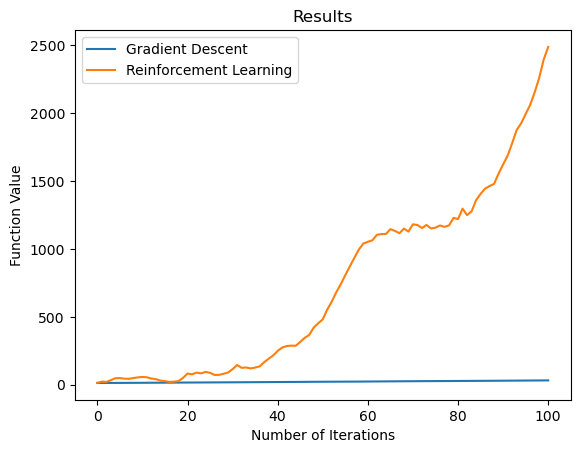

In [17]:
plt.plot(val_gd, label ="Gradient Descent")
plt.plot(val_rl, label ="Reinforcement Learning")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Function Value")
plt.title("Results")
plt.show()

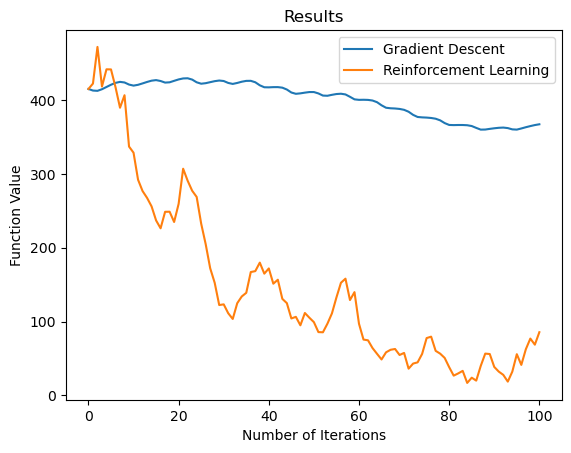

In [19]:
plt.plot(val_gd, label ="Gradient Descent")
plt.plot(val_rl, label ="Reinforcement Learning")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Function Value")
plt.title("Results")
plt.show()

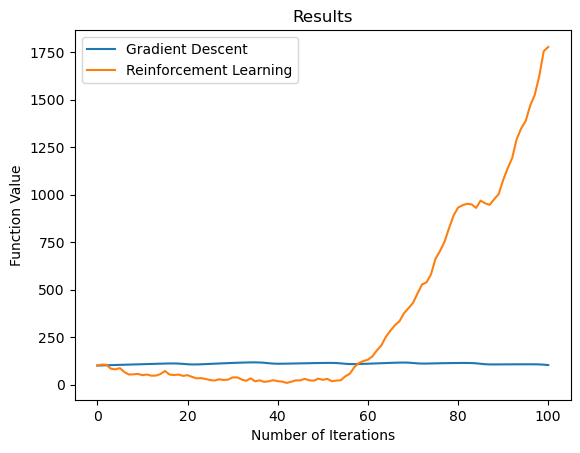

In [21]:
plt.plot(val_gd, label ="Gradient Descent")
plt.plot(val_rl, label ="Reinforcement Learning")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Function Value")
plt.title("Results")
plt.show()

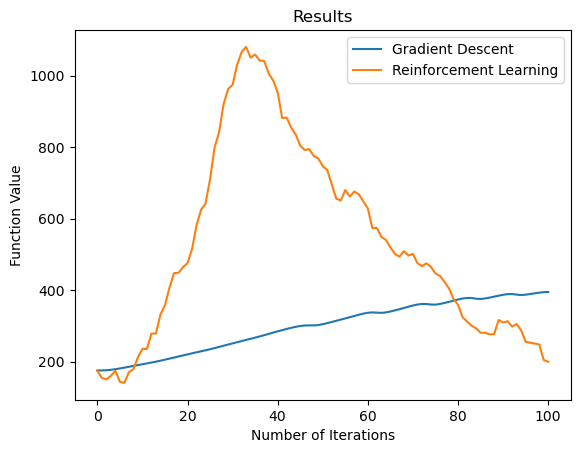

In [23]:
plt.plot(val_gd, label ="Gradient Descent")
plt.plot(val_rl, label ="Reinforcement Learning")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Function Value")
plt.title("Results")
plt.show()

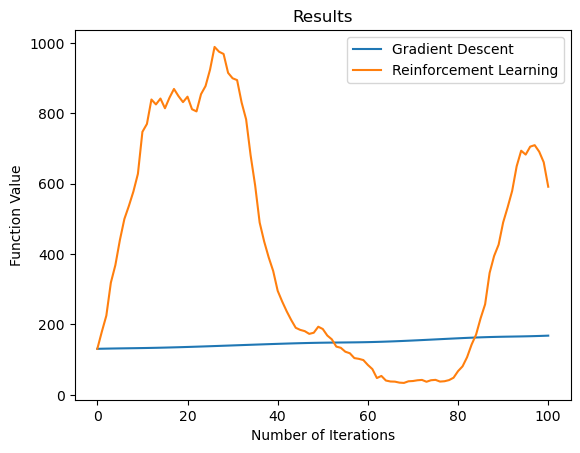

In [25]:
plt.plot(val_gd, label ="Gradient Descent")
plt.plot(val_rl, label ="Reinforcement Learning")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Function Value")
plt.title("Results")
plt.show()